<a href="https://colab.research.google.com/github/nezuk00/vis3/blob/main/lab1_california.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Лабораторная работа: Предобработка данных — California Housing

В данной лабораторной работе рассматривается процесс предобработки реального датасета **California Housing Prices**.

Цель работы — подготовить данные для последующего обучения моделей машинного обучения: выполнить загрузку, первичный анализ, обработку пропусков, кодирование категорий, масштабирование числовых признаков и построение пайплайна.

Датасет содержит информацию о жилых районах Калифорнии, включая географические координаты, демографические показатели и медианную стоимость жилья. Целевой признак — `median_house_value` (медианная стоимость дома).


## Импорт библиотек

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')


## Загрузка данных

Загрузим данные с помощью функции `fetch_california_housing` из библиотеки `sklearn`. Полученный фрейм данных содержит столбцы с исходными признаками и медианной стоимостью `MedHouseVal`. Для удобства переименуем столбцы и приведём стоимость к долларам (умножим на 100 000).

Также искусственно внесём несколько ошибок и пропусков, чтобы отработать обработку ошибок и заполнение пропусков:

- заменим одно значение в `total_rooms` на строку
- вставим пропуск в `total_bedrooms`
- представим одну стоимость в научной записи как строку

Дополнительно создадим категориальный признак `ocean_proximity` на основе широты: районы севернее 35° будем считать "NEAR BAY", южнее — "INLAND".


In [3]:

# Загрузка набора данных
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()

# Переименование столбцов для большего сходства с kaggle-версией
rename_dict = {
    'MedInc': 'median_income',
    'HouseAge': 'housing_median_age',
    'AveRooms': 'average_rooms',
    'AveBedrms': 'average_bedrooms',
    'Population': 'population',
    'AveOccup': 'households',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'MedHouseVal': 'median_house_value'
}
df.rename(columns=rename_dict, inplace=True);

# Переведем стоимость в доллары (из десятков тысяч)
df['median_house_value'] = df['median_house_value'] * 100000

# Искусственные ошибки и пропуски
# Значение total_rooms (average_rooms * households) здесь нет, поэтому для демонстрации добавим фиктивный столбец total_rooms = average_rooms * households
# (это приблизительная оценка общего количества комнат)
df['total_rooms'] = df['average_rooms'] * df['households']
df.loc[0, 'total_rooms'] = '1000 rooms'  # строковое значение вместо числа

# Вставим пропуск
df.loc[1, 'average_bedrooms'] = np.nan

# Научная запись стоимости как строка
df.loc[2, 'median_house_value'] = '3.50e05'

# Категориальный признак по близости к океану
# Для простоты: севернее 35° широты - ближе к заливу, южнее - внутренний район
df['ocean_proximity'] = np.where(df['latitude'] >= 35, 'NEAR BAY', 'INLAND')

# Выведем первые строки
print(df.head())


   median_income  housing_median_age  average_rooms  average_bedrooms  \
0         8.3252                41.0       6.984127          1.023810   
1         8.3014                21.0       6.238137               NaN   
2         7.2574                52.0       8.288136          1.073446   
3         5.6431                52.0       5.817352          1.073059   
4         3.8462                52.0       6.281853          1.081081   

   population  households  latitude  longitude median_house_value total_rooms  \
0       322.0    2.555556     37.88    -122.23           452600.0  1000 rooms   
1      2401.0    2.109842     37.86    -122.22           358500.0   13.161483   
2       496.0    2.802260     37.85    -122.24            3.50e05    23.22551   
3       558.0    2.547945     37.85    -122.25           341300.0   14.822293   
4       565.0    2.181467     37.85    -122.25           342200.0   13.703657   

  ocean_proximity  
0        NEAR BAY  
1        NEAR BAY  
2        NEAR 

## Первичный анализ данных

Для начала исследуем набор данных: выведем общую информацию, проверим наличие пропусков, посчитаем базовые статистики и построим визуализации для основных признаков.


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_income       20640 non-null  float64
 1   housing_median_age  20640 non-null  float64
 2   average_rooms       20640 non-null  float64
 3   average_bedrooms    20640 non-null  float64
 4   population          20640 non-null  float64
 5   households          20640 non-null  float64
 6   latitude            20640 non-null  float64
 7   longitude           20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   total_rooms         20640 non-null  float64
 10  ocean_proximity     20640 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.7+ MB

Статистические характеристики (числовые колонки):

       median_income  housing_median_age  average_rooms  average_bedrooms  \
count   20640.000000        20640.000000   20640.00

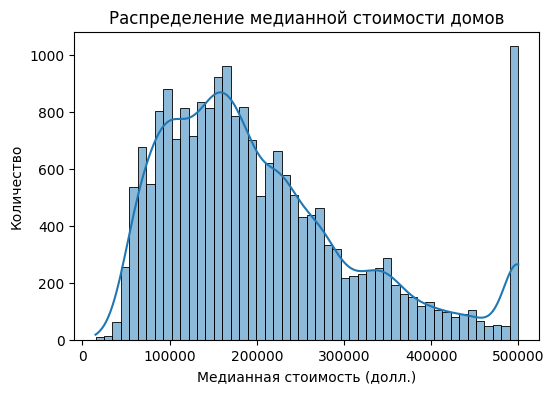

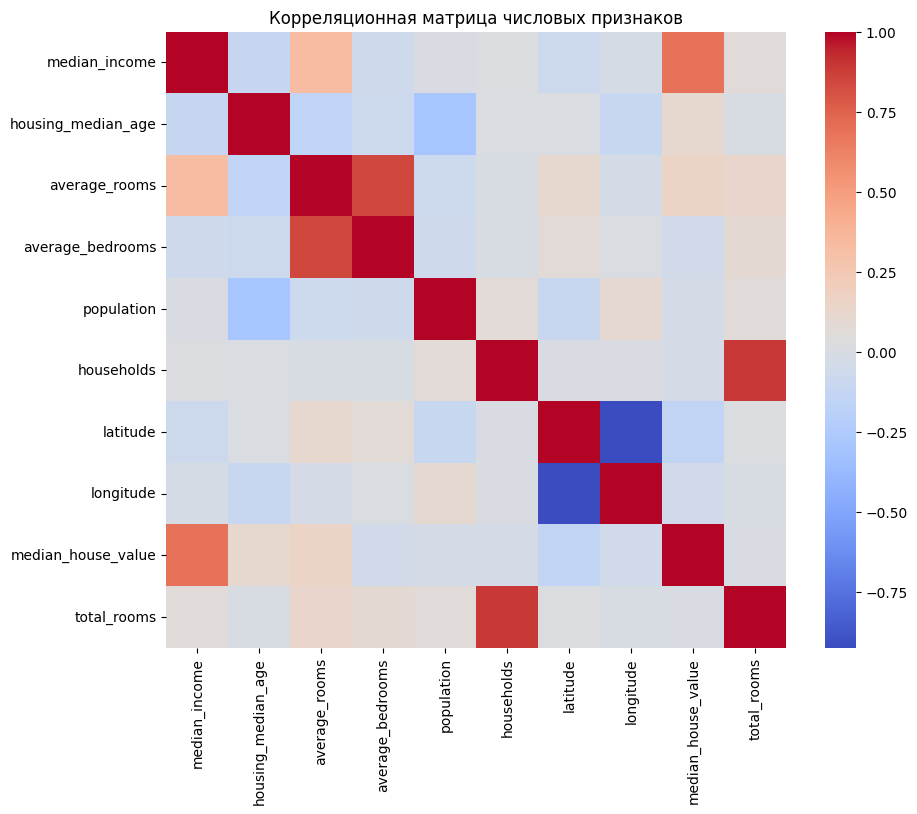

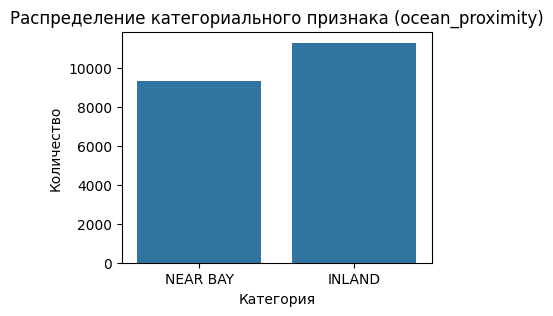

In [6]:

# Информация о данных
print("Информация о данных:")
df_info = df.info()

# Статистические параметры
print("\nСтатистические характеристики (числовые колонки):\n")
print(df.describe(include=[np.number]))

# Число пропусков по каждому столбцу
print("\nКоличество пропусков в каждом столбце:\n")
print(df.isnull().sum())

# Гистограмма целевого признака
plt.figure(figsize=(6,4))
sns.histplot(df['median_house_value'].astype(float), bins=50, kde=True)
plt.title('Распределение медианной стоимости домов')
plt.xlabel('Медианная стоимость (долл.)')
plt.ylabel('Количество')
plt.show()

# Корреляционная матрица (только числовые признаки)
plt.figure(figsize=(10,8))
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

# Распределение категориального признака ocean_proximity
plt.figure(figsize=(4,3))
sns.countplot(x='ocean_proximity', data=df)
plt.title('Распределение категориального признака (ocean_proximity)')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.show()


## Обработка пропусков и ошибок

1. **Приведение типов:** значения в столбцах должны быть числовыми. Заменим строки на числа (например, `'1000 rooms'` → `1000`).
2. **Обнаружение выбросов:** уже на этапе визуализаций видно, что признаки могут иметь существенные выбросы. В этой лабораторной будем только идентифицировать выбросы, оставив их в данных.
3. **Заполнение пропусков:** для числовых колонок будем использовать медиану, для категориальных — наиболее частую категорию.


In [5]:

# Приведение типов
# total_rooms: извлечем число из строки
# если значение не число, заменим его на NaN и потом заполним

def parse_total_rooms(x):
    try:
        return float(str(x).split()[0])
    except:
        return np.nan

df['total_rooms'] = df['total_rooms'].apply(parse_total_rooms)

# median_house_value: преобразуем строку с научной записью к числу

def parse_house_value(x):
    try:
        return float(x)
    except:
        return np.nan

df['median_house_value'] = df['median_house_value'].apply(parse_house_value)

# Заполнение пропусков: медиана для числовых, мода для категориальных
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = ['ocean_proximity']

# Заполним числовые колонки медианой
for col in numeric_cols:
    median = df[col].median()
    df[col].fillna(median, inplace=True)

# Заполним категориальные колонки модой
for col in categorical_cols:
    mode = df[col].mode()[0]
    df[col].fillna(mode, inplace=True)

# Проверим, что пропусков больше нет
print(df.isnull().sum())


median_income         0
housing_median_age    0
average_rooms         0
average_bedrooms      0
population            0
households            0
latitude              0
longitude             0
median_house_value    0
total_rooms           0
ocean_proximity       0
dtype: int64


## Кодирование категориальных признаков

Категориальный признак `ocean_proximity` необходимо преобразовать в числовую форму. Используем **One-Hot Encoding** посредством `OneHotEncoder`.


In [9]:

# Определим числовые и категориальные признаки
# numeric_cols obtained from df.select_dtypes(include=[np.number]).columns includes 'median_house_value'
# We need to exclude the target variable from features used for preprocessing
num_features = [col for col in numeric_cols if col != 'median_house_value']
cat_features = ['ocean_proximity']

# Создадим трансформеры для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Соберём ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


## Масштабирование числовых признаков и итоговый пайплайн

После кодирования категорий проведём стандартизацию числовых признаков с помощью `StandardScaler` и соберём общий пайплайн предобработки.


In [10]:

# Применим пайплайн к данным (без разделения на обучающую и тестовую выборки — это будет в следующей лабораторной)
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Обработаем данные
X_processed = preprocessor.fit_transform(X)

print("Размер обработанной матрицы признаков:", X_processed.shape)


Размер обработанной матрицы признаков: (20640, 11)


## Выводы

В ходе лабораторной работы была выполнена комплексная предобработка датасета **California Housing Prices**:

- Загружены данные, переименованы столбцы и создан дополнительный категориальный признак `ocean_proximity`.
- Выявлены и исправлены искусственно внесённые ошибки (строки вместо чисел, пропуски, научная запись).
- Проведён первичный анализ данных: осмотр структуры, подсчёт статистических характеристик, построены гистограммы и корреляционная матрица.
- Выполнена очистка данных: заполнение пропусков медианой/модой, приведение типов.
- Проведено кодирование категориального признака с помощью One-Hot Encoding.
- Выполнена стандартизация числовых признаков и собран итоговый пайплайн предобработки с использованием `ColumnTransformer` и `Pipeline`.

Подготовленный пайплайн можно использовать для дальнейшего обучения моделей машинного обучения и построения нейронных сетей на очищенных и масштабированных данных.
